### Imports and cluster environment

In [ ]:
import multiprocessing
import pandas as pd
from sim.model import elfi_sim
from sim.sum_stats import elfi_summary
import tskit
import allel
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import elfi
import scipy.stats
from sklearn.preprocessing import StandardScaler
import graphviz

import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.WARNING)

#multiprocessing.freeze_support()
#elfi.set_client('multiprocessing')



### Create pseudo-observed data

In [ ]:
y_obs = elfi_sim(length=int(5e6),
            recombination_rate=1.8e-8,
            mutation_rate=6e-8,
            pop_size_domestic_1=[100],
            pop_size_wild_1=[100],
            pop_size_captive=[100],
            captive_time=[20],
            mig_rate_captive=[0.01],
            mig_length_wild=[20],
            mig_rate_wild=[0.01],
            pop_size_domestic_2=[100],
            pop_size_wild_2=[100],
            div_time=[20000],
            mig_rate_post_split=[0.1],
            mig_length_post_split=[1000],
            bottleneck_time_wild=[3000],
            bottleneck_strength_wild=[10000],
            bottleneck_time_domestic=[3000],
            bottleneck_strength_domestic=[10000],
            random_state=np.random.RandomState(3),
            batch_size=1)

### Set up prior and constants

In [ ]:
"""
length = elfi.Constant(int(5e6))
recombination_rate = elfi.Constant(1.8e-8)
mutation_rate = elfi.Constant(6e-8)
pop_size_domestic_1 = elfi.Prior(scipy.stats.uniform, 100, 10000-100)  # scipy.stats.uniform(100, 15000),
pop_size_wild_1 = elfi.Prior(scipy.stats.lognorm, 0.4, 0, np.exp(8))  # scipy.stats.lognorm(0.4, scale=np.exp(8.5)),
pop_size_captive = elfi.Prior(scipy.stats.lognorm, 0.3, 0, np.exp(4.5))
mig_rate_captive = elfi.Prior(scipy.stats.beta, 1.2, 40)
captive_time = elfi.Prior(scipy.stats.lognorm, 0.7, 0, np.exp(3))
mig_length_wild = elfi.Prior(scipy.stats.lognorm, 0.7, 0, np.exp(3))
mig_rate_wild = elfi.Prior(scipy.stats.beta(2, 50))              
pop_size_domestic_2 = elfi.Prior(scipy.stats.uniform, 1000, 20000-1000)  # scipy.stats.uniform(1000, 25000),
pop_size_wild_2 = elfi.Prior(scipy.stats.lognorm, 0.2, 0, np.exp(8.8))  # scipy.stats.lognorm(0.2, scale=np.exp(9.2)),
bottleneck_strength_domestic = elfi.Prior(scipy.stats.uniform, 0, 40000-0)
bottleneck_time_domestic = elfi.Prior(scipy.stats.norm, 3500, 600)
bottleneck_strength_wild = elfi.Prior(scipy.stats.uniform, 0, 40000-0)
bottleneck_time_wild = elfi.Prior(scipy.stats.norm, 3500, 600)
mig_length_post_split = elfi.Prior(scipy.stats.uniform, 0, 10000-0)
mig_rate_post_split = elfi.Prior(scipy.stats.truncnorm, 0, 1, 0, 0.1)
div_time = elfi.Prior(scipy.stats.norm, 40000, 5000)
"""
pass

In [ ]:
# Test priors
length = elfi.Constant(int(5e6))
recombination_rate = elfi.Constant(1.8e-8)
mutation_rate = elfi.Constant(6e-8)
pop_size_domestic_1 = elfi.Prior(scipy.stats.truncnorm(-2, np.inf, 60, 10))  # scipy.stats.uniform(100, 15000),
pop_size_wild_1 = elfi.Prior(scipy.stats.truncnorm(-2, np.inf, 60, 10))  # scipy.stats.lognorm(0.4, scale=np.exp(8.5)),
pop_size_captive = elfi.Prior(scipy.stats.truncnorm(-2, np.inf, 60, 10))
mig_rate_captive = elfi.Prior(scipy.stats.beta, 1.2, 40)
captive_time = elfi.Prior(scipy.stats.lognorm, 0.7, 0, np.exp(3))
mig_length_wild = elfi.Prior(scipy.stats.lognorm, 0.7, 0, np.exp(3))
mig_rate_wild = elfi.Prior(scipy.stats.beta(2, 50))              
pop_size_domestic_2 = elfi.Prior(scipy.stats.truncnorm(-2, np.inf, 60, 10))  # scipy.stats.uniform(1000, 25000),
pop_size_wild_2 = elfi.Prior(scipy.stats.truncnorm(-2, np.inf, 60, 10))  # scipy.stats.lognorm(0.2, scale=np.exp(9.2)),
bottleneck_strength_domestic = elfi.Prior(scipy.stats.uniform, 0, 20000-0)
bottleneck_time_domestic = elfi.Prior(scipy.stats.norm, 3500, 300)
bottleneck_strength_wild = elfi.Prior(scipy.stats.uniform, 0, 20000-0)
bottleneck_time_wild = elfi.Prior(scipy.stats.norm, 3500, 300)
mig_length_post_split = elfi.Prior(scipy.stats.uniform, 0, 10000-0)
mig_rate_post_split = elfi.Prior(scipy.stats.truncnorm, 0, 1, 0, 0.1)
div_time = elfi.Prior(scipy.stats.norm, 20000, 1000)

In [ ]:
dist = scipy.stats.truncnorm(-2, np.inf, 60, 10)
x = np.linspace(0,100,1000)
y = dist.pdf(x)

In [ ]:
plt.plot(x, y, "r-")

### Initiate simulator node

In [ ]:
y = elfi.Simulator(elfi_sim,
                   length, recombination_rate, mutation_rate, pop_size_domestic_1, pop_size_wild_1,
                   pop_size_captive, mig_rate_captive, mig_length_wild, mig_rate_wild,
                   captive_time, pop_size_domestic_2, pop_size_wild_2, div_time, mig_rate_post_split,
                   mig_length_post_split, bottleneck_time_wild, bottleneck_strength_wild,
                   bottleneck_time_domestic, bottleneck_strength_domestic, name="simulator", observed=y_obs)
s = elfi.Summary(elfi_summary, y, name='s')

d = elfi.Distance('euclidean', s, name='d')


In [ ]:
# elfi.draw(s)

### Carry out simulations to "train" scaler

In [ ]:
seed = 1
pool = elfi.OutputPool(['s'])
rej = elfi.Rejection(d, batch_size=4, seed=1, pool=pool)
rej_res = rej.sample(32, quantile=1)  # Accept all
store = pool.get_store('s')
sum_stats = np.array(list(store.values()))
sum_stats = sum_stats.reshape(-1, sum_stats.shape[2])  # Drop batches axis
scaler = StandardScaler() # StandardScaler()
scaler.fit(sum_stats)

### Test scaling params

In [ ]:
# New priors
length.become(elfi.Constant(int(5e6)))
recombination_rate.become(elfi.Constant(1.8e-8))
mutation_rate.become(elfi.Constant(6e-8))
pop_size_domestic_1.become(elfi.Prior(scipy.stats.uniform, -1, 2))  # scipy.stats.uniform(100, 15000),
pop_size_wild_1.become(elfi.Prior(scipy.stats.uniform, -1, 2))  # scipy.stats.lognorm(0.4, scale=np.exp(8.5)),
pop_size_captive.become(elfi.Prior(scipy.stats.uniform, -1, 2))
mig_rate_captive.become(elfi.Prior(scipy.stats.uniform, -1, 2))
captive_time.become(elfi.Prior(scipy.stats.uniform, -1, 2))
mig_length_wild.become(elfi.Prior(scipy.stats.uniform, -1, 2))
mig_rate_wild.become(elfi.Prior(scipy.stats.uniform, -1, 2))           
pop_size_domestic_2.become(elfi.Prior(scipy.stats.uniform, -1, 2))  # scipy.stats.uniform(1000, 25000),
pop_size_wild_2.become(elfi.Prior(scipy.stats.uniform, -1, 2))  # scipy.stats.lognorm(0.2, scale=np.exp(9.2)),
bottleneck_strength_domestic.become(elfi.Prior(scipy.stats.uniform, -1, 2))
bottleneck_time_domestic.become(elfi.Prior(scipy.stats.uniform, -1, 2))
bottleneck_strength_wild.become(elfi.Prior(scipy.stats.uniform, -1, 2))
bottleneck_time_wild.become(elfi.Prior(scipy.stats.uniform, -1, 2))
mig_length_post_split.become(elfi.Prior(scipy.stats.uniform, -1, 2))
mig_rate_post_split.become(elfi.Prior(scipy.stats.uniform, -1, 2))
div_time.become(elfi.Prior(scipy.stats.uniform, -1, 2))

In [ ]:
param_scaler = StandardScaler()
param_scaler.fit(rej_res.samples_array)

def elfi_sim_scaled(*args, batch_size, random_state):
    constants = args[:3]
    params = np.array(args[3:]).T
    params_with_priors = param_scaler.inverse_transform(params).T.tolist()

    results = elfi_sim(*args[:3], *params_with_priors, random_state, batch_size)
    return results



y.become(elfi.Simulator(elfi_sim_scaled,
                   length, recombination_rate, mutation_rate, pop_size_domestic_1, pop_size_wild_1,
                   pop_size_captive, mig_rate_captive, mig_length_wild, mig_rate_wild,
                   captive_time, pop_size_domestic_2, pop_size_wild_2, div_time, mig_rate_post_split,
                   mig_length_post_split, bottleneck_time_wild, bottleneck_strength_wild,
                   bottleneck_time_domestic, bottleneck_strength_domestic, name="simulator_scaled", observed=y_obs))

### Scale summaries

In [ ]:
def elfi_summary_scaled(*args):  # This function might not get pushed to workers properly?
    sum_stats = elfi_summary(*args)
    sum_stats = scaler.transform(sum_stats)
    return sum_stats

s.become(elfi.Summary(elfi_summary_scaled, y, name='scaled_s'))



### Run SMC

In [ ]:
smc = elfi.SMC(d, seed=2, batch_size=10)
smc_res = smc.sample(30, [18, 17])  # Probably an issue with narrow uniform priors?

In [ ]:
import joblib
x = joblib.load("x.joblib")
means = joblib.load("means.joblib")
weights = joblib.load("weights.joblib")

In [ ]:
from scipy.stats import multivariate_normal
d = np.zeros(len(x))
for m, w in zip(means, weights):
    d += w * multivariate_normal.pdf(x, mean=m, cov=1)

In [ ]:
weights.shape

### Bug reasons?
- All the weights are 0.0333 (i.e. 1/30 - the number of simulations) That shouldn't be an issue I don't think. However, why would the weights be equal when they should be based on
- The pdf at the quantiles x are all zero... Hence there's no way to know how to perturb the particle by drawing random values from the multivariate gaussian?



### Test tutorial smc scaling

In [1]:
import elfi
import scipy.stats
import numpy as np


def MA2(t1, t2, n_obs=100, batch_size=1, random_state=None):
    # Make inputs 2d arrays for numpy broadcasting with w
    t1 = t1/1e5
    t1 = np.asanyarray(t1).reshape((-1, 1))
    t2 = np.asanyarray(t2).reshape((-1, 1))
    random_state = random_state or np.random

    w = random_state.randn(batch_size, n_obs+2)  # i.i.d. sequence ~ N(0,1)
    x = w[:, 2:] + t1*w[:, 1:-1] + t2*w[:, :-2]
    return x

In [2]:
t1 = elfi.Prior(scipy.stats.uniform, 0, 2e5)
t2 = elfi.Prior('uniform', 0, 2)

t1_true = 0.6
t2_true = 0.2
y_obs = MA2(t1_true, t2_true)

Y = elfi.Simulator(MA2, t1, t2, observed=y_obs)

def autocov(x, lag=1):
    C = np.mean(x[:,lag:] * x[:,:-lag], axis=1)
    return C


S1 = elfi.Summary(autocov, Y)
S2 = elfi.Summary(autocov, Y, 2)  # the optional keyword lag is given the value 2
d = elfi.Distance('euclidean', S1, S2)



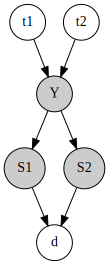

In [3]:
elfi.draw(d)

In [4]:
smc = elfi.SMC(d, batch_size=10000, seed=1)

In [5]:
N = 1000
schedule = [0.7, 0.3, 0.05]
%time result_smc = smc.sample(N, schedule)

LinAlgError: singular matrix

NameError: name 'result_smc' is not defined

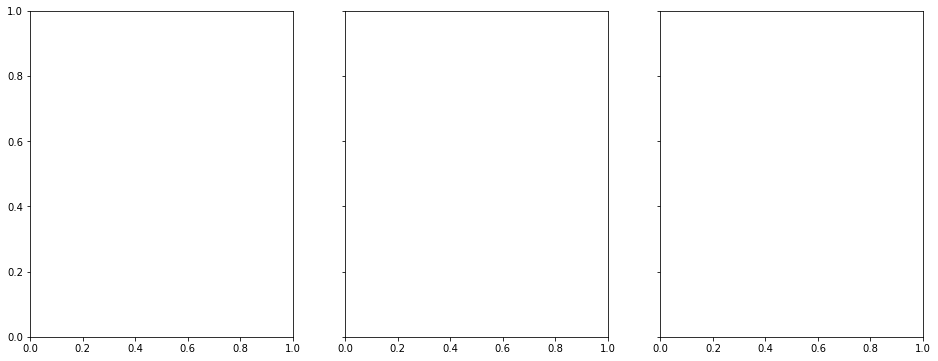

In [6]:
import matplotlib.pyplot as plt
n_populations = len(schedule)
fig, ax = plt.subplots(ncols=n_populations, sharex=True, sharey=True, figsize=(16,6))

for i, pop in enumerate(result_smc.populations):
    s = pop.samples
    ax[i].scatter(s['t1'], s['t2'], s=5, edgecolor='none');
    ax[i].set_title("Population {}".format(i));
    ax[i].plot([0, 2, -2, 0], [-1, 1, 1, -1], 'b')
    ax[i].set_xlabel('t1');
ax[0].set_ylabel('t2');
#ax[0].set_xlim([-2, 2])
#ax[0].set_ylim([-1, 1]);